In [1]:
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoTokenizer, PreTrainedTokenizerFast

In [2]:
def answer_question(model: "Llamavision", image: Image, prompt: str, tokenizer: PreTrainedTokenizerFast, **kwargs):

    # Generate input IDs from the prompt
    input_ids = (
        model.tokenizer_image_token(prompt, tokenizer, -200, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    # Define terminators for the generation process
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids(""),
    ]

    with torch.inference_mode():
        # Process the image through the specified pipeline
        image_inputs = model.processor(
            images=[image],
            return_tensors="pt",
            do_resize=True,
            size={"height": 384, "width": 384},
        )

        image_inputs = image_inputs["pixel_values"].to(
            device=model.device, dtype=model.dtype
        )

        # Generate image features using the vision model
        image_forward_outs = model.vision_model(
            image_inputs,
            output_hidden_states=True,
        )

        image_features = image_forward_outs.hidden_states[-2]

        # Project the embeddings to match the text model space
        projected_embeddings = model.mm_projector(image_features).to(model.device)

        # Fetch the embedding layer from the text model
        embedding_layer = model.text_model.get_input_embeddings()

        # Combine text and image embeddings
        new_embeds, attn_mask = model.process_tensors(
            input_ids, projected_embeddings, embedding_layer
        )

        attn_mask = attn_mask.to(model.device)
        new_embeds = new_embeds.to(model.device)

        # Generate an answer using the combined embeddings
        answer = model.text_model.generate(
            inputs_embeds=new_embeds,
            attention_mask=attn_mask,
            eos_token_id=terminators,
            temperature=0.2,
            do_sample=True,
            **kwargs,
        )[0]

        return answer


In [3]:
model_id = "qresearch/llama-3-vision-alpha-hf"
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True, torch_dtype=torch.float16
).to("mps")

/Users/ariel/projects/wildcats-ai/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:

tokenizer = AutoTokenizer.from_pretrained(
    model_id,
    use_fast=True,
)

/Users/ariel/projects/wildcats-ai/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [59]:
tokens = tokenizer.apply_chat_template(
[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "<image>What is the name of the game?"},
    {"role": "assistant", "content": "The name of the game is:"}
])

print(tokenizer.decode(tokens))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

<image>What is the name of the game?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The name of the game is:<|eot_id|>


In [63]:
def format_prompt(messages: list[dict[str, str]], last_prefilled: bool = False) -> str:
    BEGIN = "<|begin_of_text|>"
    START_ID = "<|start_header_id|>"
    END_ID = "<|end_header_id|>"
    EOT = "<|eot_id|>"
    
    prompt = f"{BEGIN}"
    
    size = len(messages)
    
    for i, message in enumerate(messages):
        role = message["role"]
        content = message["content"]
        
        prompt += f"{START_ID}{role}{END_ID}"
        prompt += "\n\n"
        prompt += content
        if i < size - 1 or not last_prefilled:
            prompt += EOT
            
    return prompt
    
    

In [68]:
prompt = format_prompt(
[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "<image>What is the name of the game?"},
    {"role": "assistant", "content": "The name of the game is"}
], True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

<image>What is the name of the game?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The name of the game is


In [11]:

image = Image.open("images/steam.png").convert("RGB")

In [71]:
answer_question(model, image, prompt, tokenizer)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


RuntimeError: Could not infer dtype of NoneType

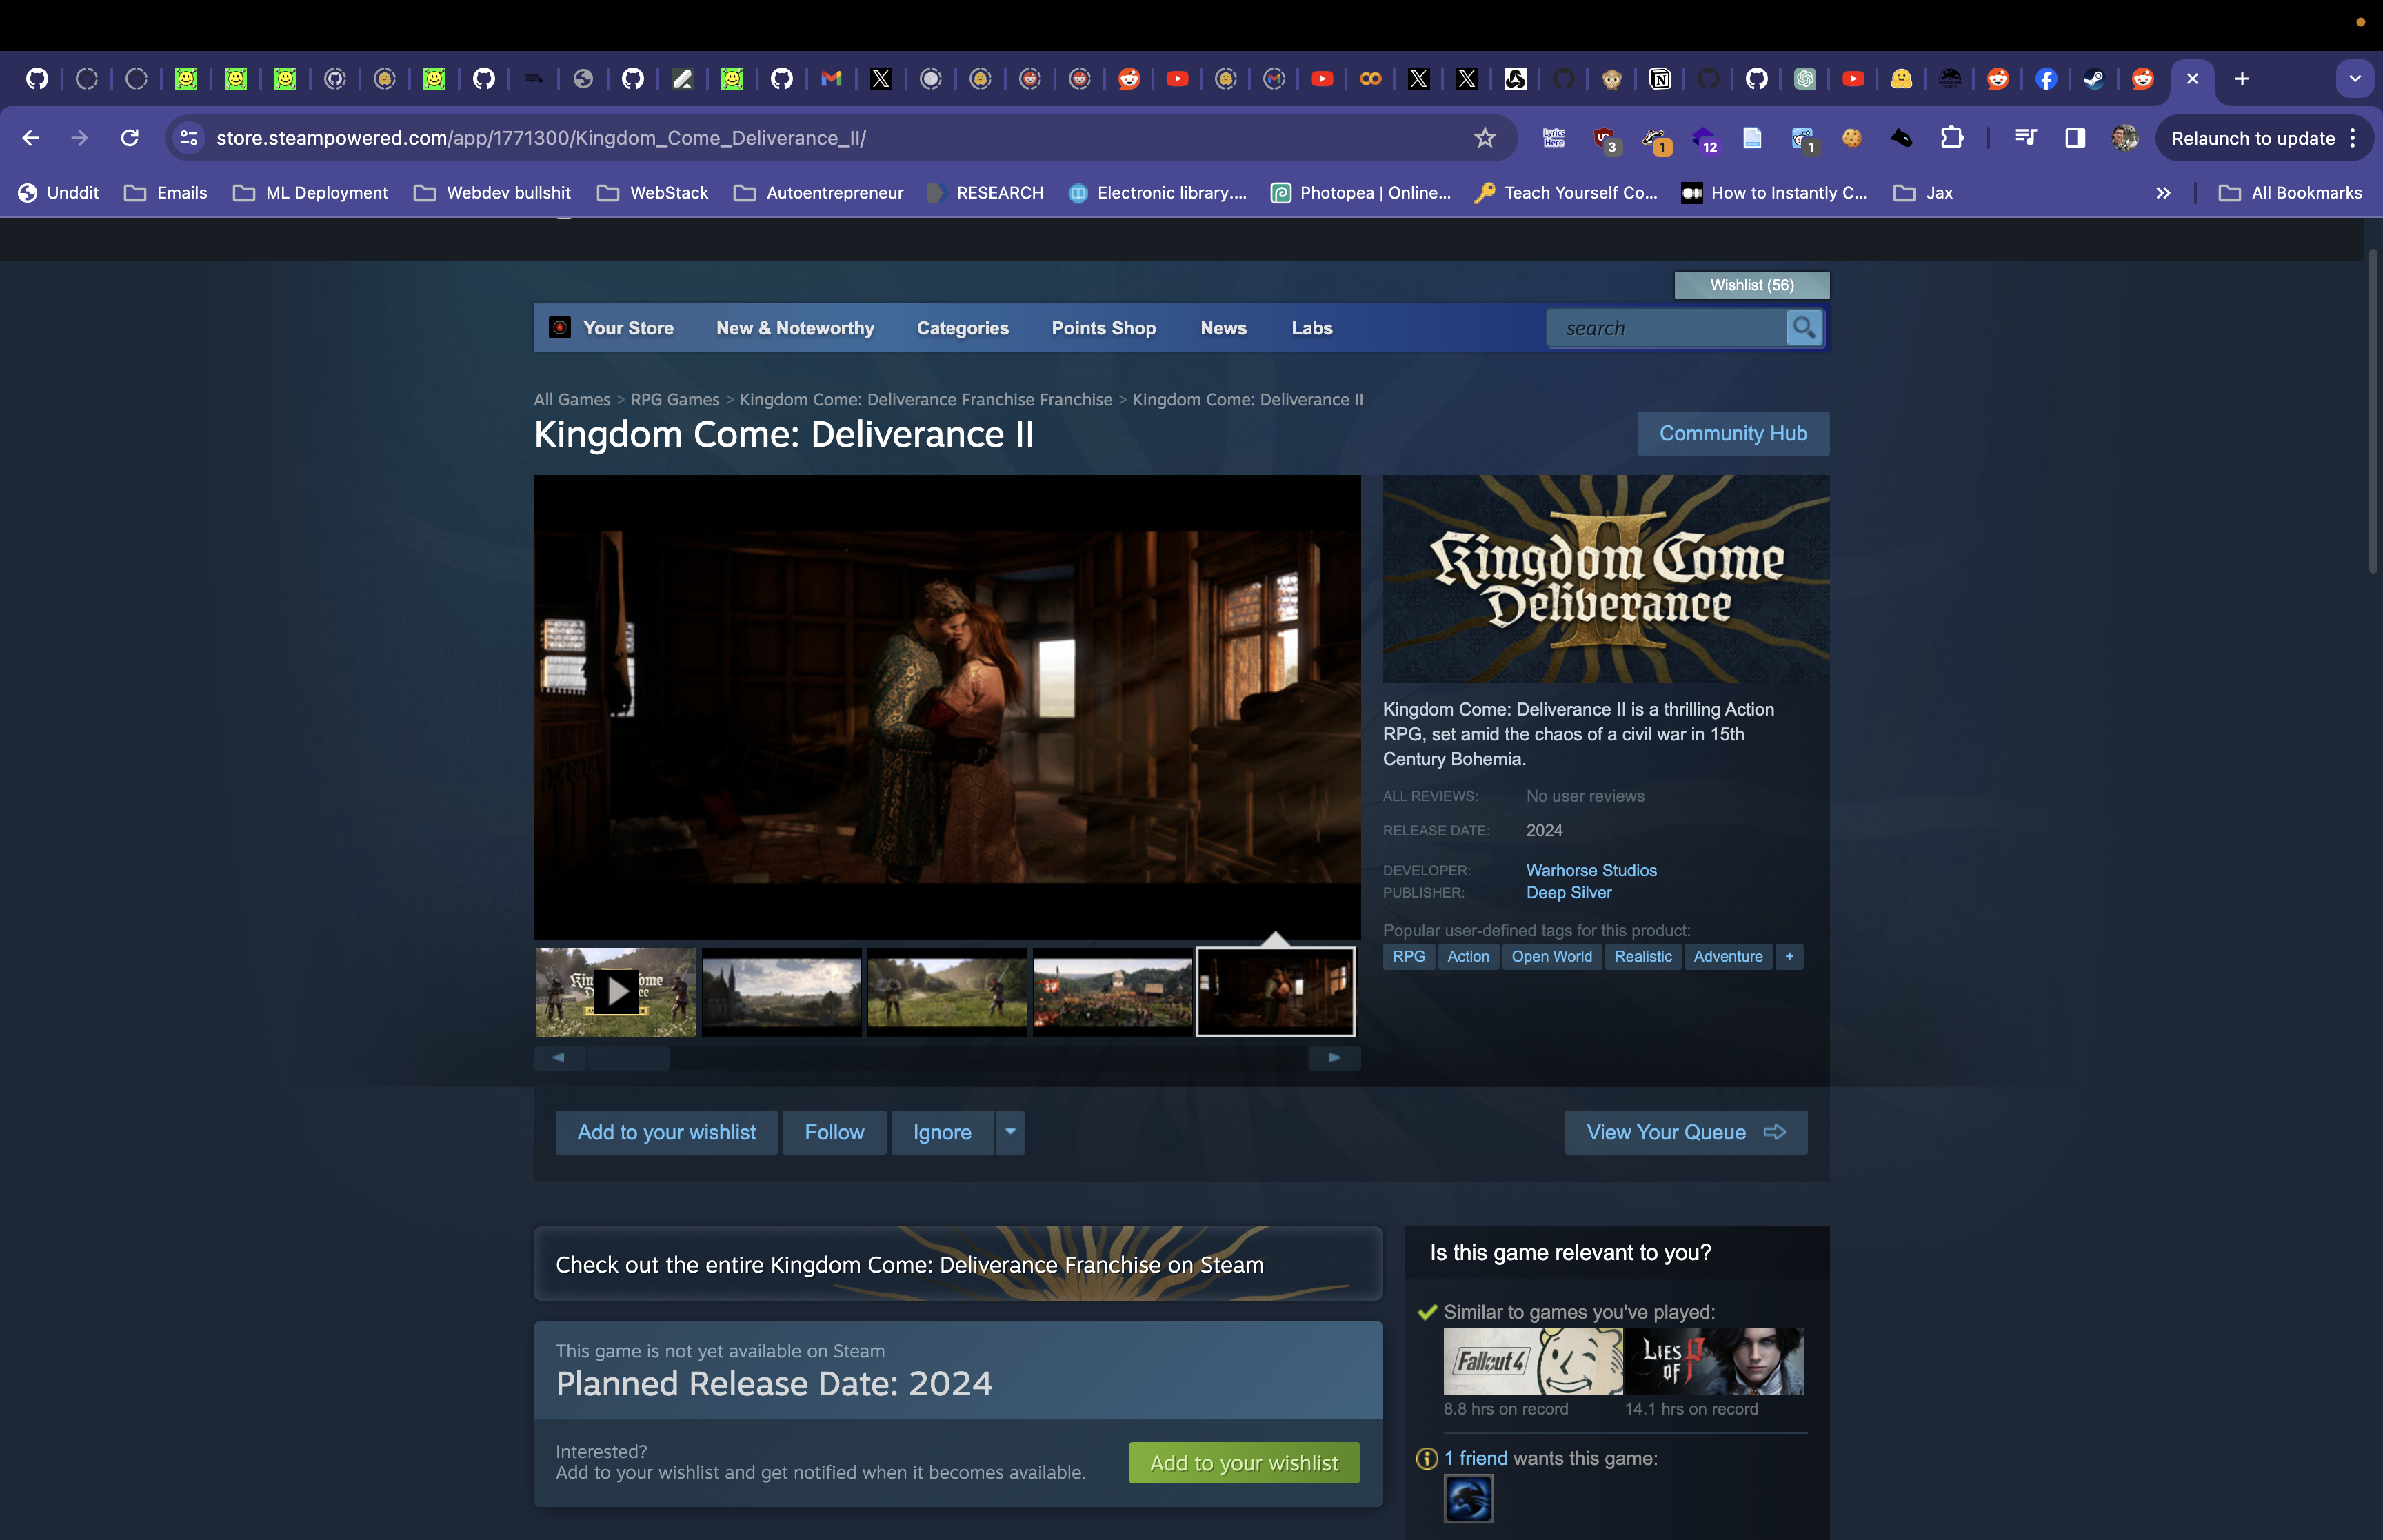

In [6]:
image

In [17]:
res = model.answer_question(image, "What two games are in the bottom right corner of the image marked as similar? Write only the names separated by a comma. Do not write any other commentary", tokenizer)
tokenizer.decode(res, skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


'Based on the image, the two games in the bottom right corner marked as similar are:\n\nRise of the Kingdoms, Kingdom Come: Deliverance'